# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F 
import torch.optim as optim

In [2]:
train_dataset = torchvision.datasets.MNIST('.', train = True, download = True)
test_dataset = torchvision.datasets.MNIST('.', train = False, download = True)

In [3]:
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
])
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
])


In [4]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [5]:
m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m*0.8), int(m*0.2)])
batch_size = 256

In [6]:
print(m)
print(len(train_data) / m)

print(len(val_data) / m)

60000
0.8
0.2


In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# encoder section

In [8]:
class Encoder(nn.Module):

  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()

    ## Convolutional Section
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride = 2, padding = 0),
        nn.ReLU(True)
        )
    
    ## Flatten Layer
    self.flatten = nn.Flatten(start_dim = 1)

    ##Linear Section
    self.encoder_lin = nn.Sequential(
        nn.Linear(3 * 3 * 32, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
    )

  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

# decoder section

In [9]:
class Decoder(nn.Module):

  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()

    self.decoder_lin = nn.Sequential(
        nn.Linear(encoded_space_dim, 128),
        nn.ReLU(True),
        nn.Linear(128, 3 * 3 * 32),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim = 1, unflattened_size = (32, 3, 3))

    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3, stride = 2, output_padding = 0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1, output_padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride = 2, padding = 1, output_padding = 1)
    )

  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

# training config

In [10]:
loss_fn = torch.nn.MSELoss()

lr = 0.001

d = 4

In [11]:
encoder = Encoder(encoded_space_dim = d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim = d, fc2_input_dim=128)
params_to_optimize = [ 
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
]

In [12]:
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f'Selected device: {device}')

Selected device: cuda


# summary

In [14]:
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# training

In [15]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
  encoder.train()
  decoder.train()
  train_loss = []
  for image_batch, _ in dataloader:
    #Move tensor to device
    image_batch = image_batch.to(device)
    #Encode data
    encoded_data = encoder(image_batch)
    decoded_data = decoder(encoded_data)

    loss = loss_fn(decoded_data, image_batch)

    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print batch loss
    print(
        '\t partial train loss (single batch): %f' % (loss.data)
    )
    train_loss.append(loss.detach().cpu().numpy())

In [16]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
      #Move tensor to device
      image_batch = image_batch.to(device)
      
      encoded_data = encoder(image_batch)
      decoded_data = decoder(encoded_data)

      #append the network output and the original image to the lists
      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())
    
    #create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)

    #evaluate global loss
    val_loss = loss_fn(conc_out, conc_label)
  
  return val_loss.data

In [17]:
def plot_ae_outputs(encoder, decoder, n=10):
  plt.figure(figsize = (16,4.5))
  targets = test_dataset.targets.numpy()
  t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
  for i in range(n):
    ax = plt.subplot(2, n, i+1)
    img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      rec_img = decoder(encoder(img))
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
      ax.set_title('Original images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
      ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.254584
	 partial train loss (single batch): 0.249655
	 partial train loss (single batch): 0.245776
	 partial train loss (single batch): 0.243012
	 partial train loss (single batch): 0.239995
	 partial train loss (single batch): 0.236971
	 partial train loss (single batch): 0.235000
	 partial train loss (single batch): 0.232746
	 partial train loss (single batch): 0.231015
	 partial train loss (single batch): 0.228863
	 partial train loss (single batch): 0.226792
	 partial train loss (single batch): 0.224708
	 partial train loss (single batch): 0.222915
	 partial train loss (single batch): 0.220949
	 partial train loss (single batch): 0.219163
	 partial train loss (single batch): 0.217448
	 partial train loss (single batch): 0.216186
	 partial train loss (single batch): 0.213870
	 partial train loss (single batch): 0.212845
	 partial train loss (single batch): 0.210518
	 partial train loss (single batch): 0.209543
	 partial train loss (single batch

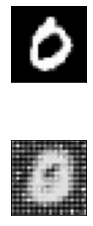

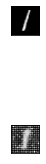

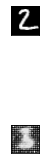

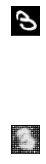

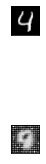

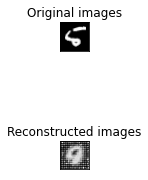

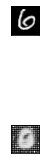

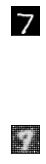

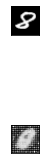

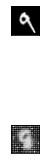

	 partial train loss (single batch): 0.083229
	 partial train loss (single batch): 0.080884
	 partial train loss (single batch): 0.082831
	 partial train loss (single batch): 0.081234
	 partial train loss (single batch): 0.081326
	 partial train loss (single batch): 0.081883
	 partial train loss (single batch): 0.081522
	 partial train loss (single batch): 0.080802
	 partial train loss (single batch): 0.079186
	 partial train loss (single batch): 0.080268
	 partial train loss (single batch): 0.079548
	 partial train loss (single batch): 0.079661
	 partial train loss (single batch): 0.080639
	 partial train loss (single batch): 0.078235
	 partial train loss (single batch): 0.078643
	 partial train loss (single batch): 0.078416
	 partial train loss (single batch): 0.077586
	 partial train loss (single batch): 0.077071
	 partial train loss (single batch): 0.077495
	 partial train loss (single batch): 0.077433
	 partial train loss (single batch): 0.076586
	 partial train loss (single batch

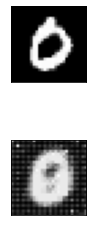

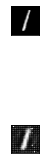

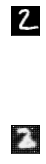

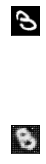

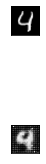

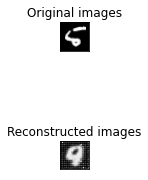

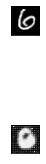

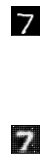

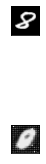

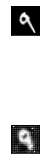

	 partial train loss (single batch): 0.055289
	 partial train loss (single batch): 0.052229
	 partial train loss (single batch): 0.055140
	 partial train loss (single batch): 0.052983
	 partial train loss (single batch): 0.053843
	 partial train loss (single batch): 0.054572
	 partial train loss (single batch): 0.054874
	 partial train loss (single batch): 0.053852
	 partial train loss (single batch): 0.052758
	 partial train loss (single batch): 0.054256
	 partial train loss (single batch): 0.053570
	 partial train loss (single batch): 0.053577
	 partial train loss (single batch): 0.055489
	 partial train loss (single batch): 0.053027
	 partial train loss (single batch): 0.053450
	 partial train loss (single batch): 0.053257
	 partial train loss (single batch): 0.052944
	 partial train loss (single batch): 0.052624
	 partial train loss (single batch): 0.052833
	 partial train loss (single batch): 0.053669
	 partial train loss (single batch): 0.052547
	 partial train loss (single batch

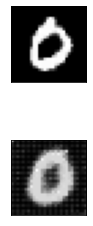

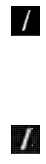

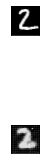

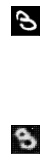

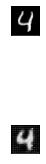

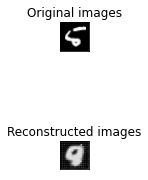

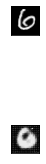

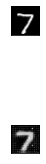

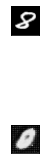

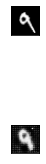

	 partial train loss (single batch): 0.048481
	 partial train loss (single batch): 0.045319
	 partial train loss (single batch): 0.048265
	 partial train loss (single batch): 0.046245
	 partial train loss (single batch): 0.047244
	 partial train loss (single batch): 0.047801
	 partial train loss (single batch): 0.048094
	 partial train loss (single batch): 0.047165
	 partial train loss (single batch): 0.046015
	 partial train loss (single batch): 0.047801
	 partial train loss (single batch): 0.047059
	 partial train loss (single batch): 0.047065
	 partial train loss (single batch): 0.049247
	 partial train loss (single batch): 0.046618
	 partial train loss (single batch): 0.046973
	 partial train loss (single batch): 0.046949
	 partial train loss (single batch): 0.046749
	 partial train loss (single batch): 0.046504
	 partial train loss (single batch): 0.046790
	 partial train loss (single batch): 0.047778
	 partial train loss (single batch): 0.046475
	 partial train loss (single batch

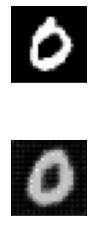

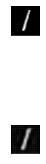

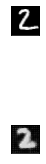

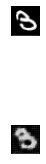

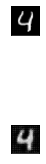

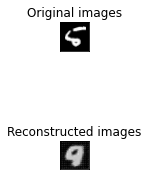

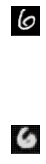

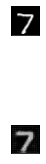

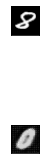

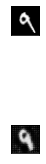

	 partial train loss (single batch): 0.045008
	 partial train loss (single batch): 0.041971
	 partial train loss (single batch): 0.044677
	 partial train loss (single batch): 0.042937
	 partial train loss (single batch): 0.043898
	 partial train loss (single batch): 0.044437
	 partial train loss (single batch): 0.044586
	 partial train loss (single batch): 0.043803
	 partial train loss (single batch): 0.042527
	 partial train loss (single batch): 0.044461
	 partial train loss (single batch): 0.043752
	 partial train loss (single batch): 0.043789
	 partial train loss (single batch): 0.046019
	 partial train loss (single batch): 0.043141
	 partial train loss (single batch): 0.043368
	 partial train loss (single batch): 0.043625
	 partial train loss (single batch): 0.043462
	 partial train loss (single batch): 0.043362
	 partial train loss (single batch): 0.043446
	 partial train loss (single batch): 0.044711
	 partial train loss (single batch): 0.043335
	 partial train loss (single batch

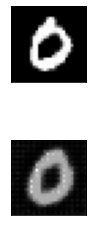

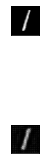

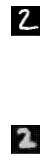

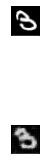

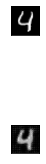

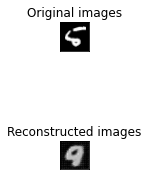

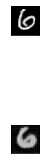

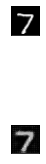

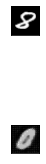

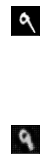

	 partial train loss (single batch): 0.042682
	 partial train loss (single batch): 0.039751
	 partial train loss (single batch): 0.042405
	 partial train loss (single batch): 0.040654
	 partial train loss (single batch): 0.041777
	 partial train loss (single batch): 0.042284
	 partial train loss (single batch): 0.042189
	 partial train loss (single batch): 0.041620
	 partial train loss (single batch): 0.040292
	 partial train loss (single batch): 0.042282
	 partial train loss (single batch): 0.041614
	 partial train loss (single batch): 0.041708
	 partial train loss (single batch): 0.043931
	 partial train loss (single batch): 0.040993
	 partial train loss (single batch): 0.041139
	 partial train loss (single batch): 0.041529
	 partial train loss (single batch): 0.041335
	 partial train loss (single batch): 0.041221
	 partial train loss (single batch): 0.041346
	 partial train loss (single batch): 0.042684
	 partial train loss (single batch): 0.041250
	 partial train loss (single batch

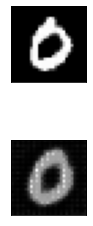

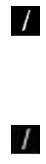

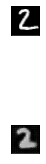

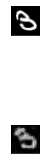

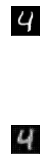

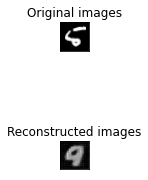

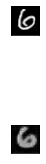

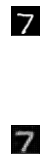

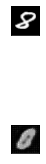

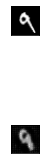

	 partial train loss (single batch): 0.040724
	 partial train loss (single batch): 0.037920
	 partial train loss (single batch): 0.040303
	 partial train loss (single batch): 0.038541
	 partial train loss (single batch): 0.039806
	 partial train loss (single batch): 0.040202
	 partial train loss (single batch): 0.040055
	 partial train loss (single batch): 0.039539
	 partial train loss (single batch): 0.038278
	 partial train loss (single batch): 0.040254
	 partial train loss (single batch): 0.039562
	 partial train loss (single batch): 0.039683
	 partial train loss (single batch): 0.041956
	 partial train loss (single batch): 0.038917
	 partial train loss (single batch): 0.039082
	 partial train loss (single batch): 0.039424
	 partial train loss (single batch): 0.039210
	 partial train loss (single batch): 0.039129
	 partial train loss (single batch): 0.039216
	 partial train loss (single batch): 0.040591
	 partial train loss (single batch): 0.039110
	 partial train loss (single batch

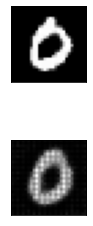

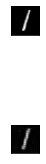

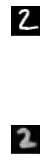

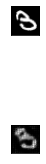

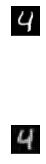

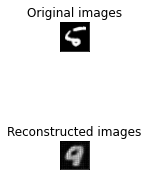

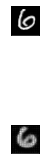

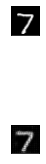

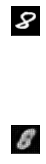

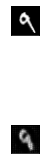

	 partial train loss (single batch): 0.037790
	 partial train loss (single batch): 0.035328
	 partial train loss (single batch): 0.036980
	 partial train loss (single batch): 0.035398
	 partial train loss (single batch): 0.036987
	 partial train loss (single batch): 0.037136
	 partial train loss (single batch): 0.036388
	 partial train loss (single batch): 0.036344
	 partial train loss (single batch): 0.035523
	 partial train loss (single batch): 0.037374
	 partial train loss (single batch): 0.036463
	 partial train loss (single batch): 0.036625
	 partial train loss (single batch): 0.038563
	 partial train loss (single batch): 0.035576
	 partial train loss (single batch): 0.035706
	 partial train loss (single batch): 0.036122
	 partial train loss (single batch): 0.035863
	 partial train loss (single batch): 0.036032
	 partial train loss (single batch): 0.035861
	 partial train loss (single batch): 0.037406
	 partial train loss (single batch): 0.035849
	 partial train loss (single batch

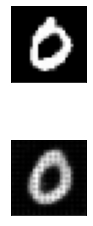

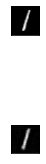

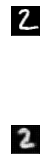

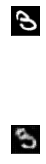

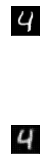

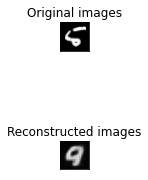

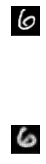

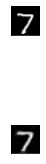

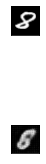

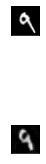

	 partial train loss (single batch): 0.033808
	 partial train loss (single batch): 0.031657
	 partial train loss (single batch): 0.032919
	 partial train loss (single batch): 0.031623
	 partial train loss (single batch): 0.033489
	 partial train loss (single batch): 0.033509
	 partial train loss (single batch): 0.031919
	 partial train loss (single batch): 0.032535
	 partial train loss (single batch): 0.032217
	 partial train loss (single batch): 0.033953
	 partial train loss (single batch): 0.032750
	 partial train loss (single batch): 0.032690
	 partial train loss (single batch): 0.034513
	 partial train loss (single batch): 0.031576
	 partial train loss (single batch): 0.031561
	 partial train loss (single batch): 0.032169
	 partial train loss (single batch): 0.031708
	 partial train loss (single batch): 0.032394
	 partial train loss (single batch): 0.032089
	 partial train loss (single batch): 0.033826
	 partial train loss (single batch): 0.032127
	 partial train loss (single batch

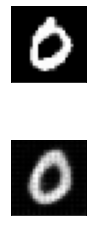

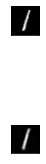

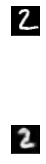

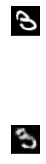

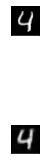

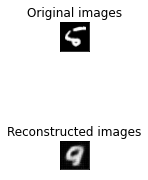

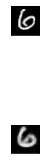

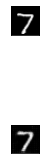

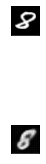

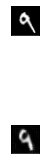

	 partial train loss (single batch): 0.032097
	 partial train loss (single batch): 0.030347
	 partial train loss (single batch): 0.031173
	 partial train loss (single batch): 0.030084
	 partial train loss (single batch): 0.032002
	 partial train loss (single batch): 0.031595
	 partial train loss (single batch): 0.030242
	 partial train loss (single batch): 0.031073
	 partial train loss (single batch): 0.030721
	 partial train loss (single batch): 0.032504
	 partial train loss (single batch): 0.031249
	 partial train loss (single batch): 0.031313
	 partial train loss (single batch): 0.032622
	 partial train loss (single batch): 0.029906
	 partial train loss (single batch): 0.030161
	 partial train loss (single batch): 0.030659
	 partial train loss (single batch): 0.030061
	 partial train loss (single batch): 0.030712
	 partial train loss (single batch): 0.030652
	 partial train loss (single batch): 0.032450
	 partial train loss (single batch): 0.030649
	 partial train loss (single batch

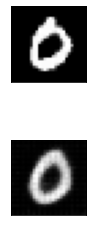

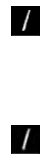

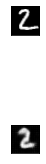

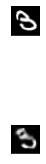

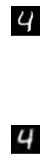

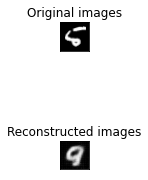

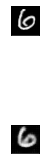

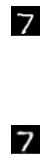

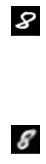

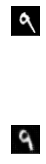

	 partial train loss (single batch): 0.031513
	 partial train loss (single batch): 0.029522
	 partial train loss (single batch): 0.030565
	 partial train loss (single batch): 0.029445
	 partial train loss (single batch): 0.031513
	 partial train loss (single batch): 0.030688
	 partial train loss (single batch): 0.029444
	 partial train loss (single batch): 0.030369
	 partial train loss (single batch): 0.030189
	 partial train loss (single batch): 0.031716
	 partial train loss (single batch): 0.030483
	 partial train loss (single batch): 0.030425
	 partial train loss (single batch): 0.031910
	 partial train loss (single batch): 0.029106
	 partial train loss (single batch): 0.029378
	 partial train loss (single batch): 0.029901
	 partial train loss (single batch): 0.029235
	 partial train loss (single batch): 0.029875
	 partial train loss (single batch): 0.029959
	 partial train loss (single batch): 0.031779
	 partial train loss (single batch): 0.029851
	 partial train loss (single batch

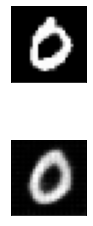

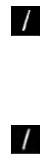

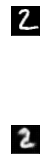

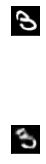

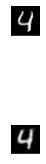

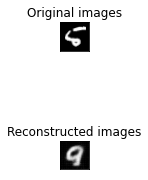

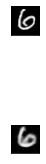

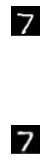

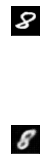

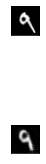

	 partial train loss (single batch): 0.030687
	 partial train loss (single batch): 0.028952
	 partial train loss (single batch): 0.030141
	 partial train loss (single batch): 0.028943
	 partial train loss (single batch): 0.031027
	 partial train loss (single batch): 0.029989
	 partial train loss (single batch): 0.028840
	 partial train loss (single batch): 0.029824
	 partial train loss (single batch): 0.029753
	 partial train loss (single batch): 0.031186
	 partial train loss (single batch): 0.029882
	 partial train loss (single batch): 0.029959
	 partial train loss (single batch): 0.031423
	 partial train loss (single batch): 0.028633
	 partial train loss (single batch): 0.028855
	 partial train loss (single batch): 0.029445
	 partial train loss (single batch): 0.028766
	 partial train loss (single batch): 0.029241
	 partial train loss (single batch): 0.029492
	 partial train loss (single batch): 0.031200
	 partial train loss (single batch): 0.029480
	 partial train loss (single batch

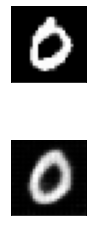

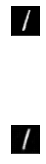

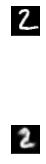

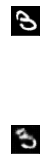

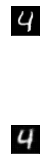

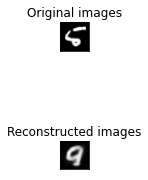

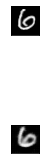

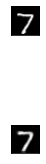

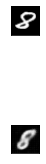

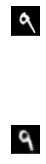

	 partial train loss (single batch): 0.030159
	 partial train loss (single batch): 0.028625
	 partial train loss (single batch): 0.029750
	 partial train loss (single batch): 0.028503
	 partial train loss (single batch): 0.030685
	 partial train loss (single batch): 0.029505
	 partial train loss (single batch): 0.028527
	 partial train loss (single batch): 0.029428
	 partial train loss (single batch): 0.029369
	 partial train loss (single batch): 0.030936
	 partial train loss (single batch): 0.029545
	 partial train loss (single batch): 0.029619
	 partial train loss (single batch): 0.031012
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.028474
	 partial train loss (single batch): 0.029141
	 partial train loss (single batch): 0.028352
	 partial train loss (single batch): 0.028777
	 partial train loss (single batch): 0.029142
	 partial train loss (single batch): 0.030786
	 partial train loss (single batch): 0.029072
	 partial train loss (single batch

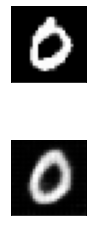

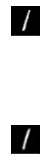

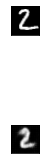

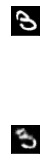

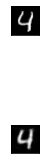

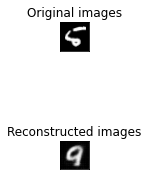

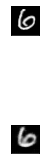

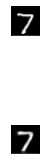

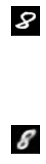

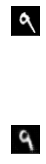

	 partial train loss (single batch): 0.029729
	 partial train loss (single batch): 0.028285
	 partial train loss (single batch): 0.029455
	 partial train loss (single batch): 0.028210
	 partial train loss (single batch): 0.030296
	 partial train loss (single batch): 0.029192
	 partial train loss (single batch): 0.028230
	 partial train loss (single batch): 0.029039
	 partial train loss (single batch): 0.029161
	 partial train loss (single batch): 0.030632
	 partial train loss (single batch): 0.029055
	 partial train loss (single batch): 0.029224
	 partial train loss (single batch): 0.030678
	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.028853
	 partial train loss (single batch): 0.028090
	 partial train loss (single batch): 0.028470
	 partial train loss (single batch): 0.028964
	 partial train loss (single batch): 0.030480
	 partial train loss (single batch): 0.028861
	 partial train loss (single batch

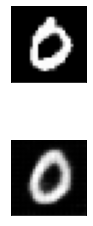

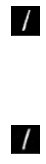

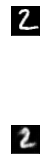

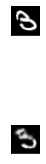

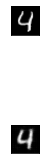

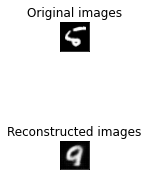

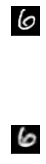

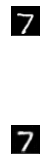

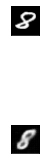

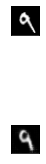

	 partial train loss (single batch): 0.029338
	 partial train loss (single batch): 0.028020
	 partial train loss (single batch): 0.029205
	 partial train loss (single batch): 0.028027
	 partial train loss (single batch): 0.030038
	 partial train loss (single batch): 0.028972
	 partial train loss (single batch): 0.027995
	 partial train loss (single batch): 0.028694
	 partial train loss (single batch): 0.028839
	 partial train loss (single batch): 0.030378
	 partial train loss (single batch): 0.028763
	 partial train loss (single batch): 0.028975
	 partial train loss (single batch): 0.030400
	 partial train loss (single batch): 0.027695
	 partial train loss (single batch): 0.027893
	 partial train loss (single batch): 0.028699
	 partial train loss (single batch): 0.027844
	 partial train loss (single batch): 0.028205
	 partial train loss (single batch): 0.028704
	 partial train loss (single batch): 0.030221
	 partial train loss (single batch): 0.028620
	 partial train loss (single batch

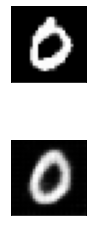

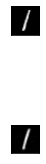

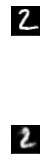

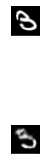

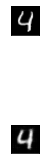

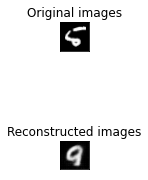

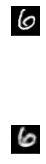

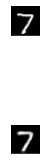

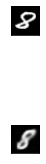

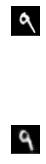

	 partial train loss (single batch): 0.029010
	 partial train loss (single batch): 0.027789
	 partial train loss (single batch): 0.028953
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.029809
	 partial train loss (single batch): 0.028688
	 partial train loss (single batch): 0.027773
	 partial train loss (single batch): 0.028510
	 partial train loss (single batch): 0.028579
	 partial train loss (single batch): 0.030153
	 partial train loss (single batch): 0.028453
	 partial train loss (single batch): 0.028748
	 partial train loss (single batch): 0.030123
	 partial train loss (single batch): 0.027467
	 partial train loss (single batch): 0.027636
	 partial train loss (single batch): 0.028530
	 partial train loss (single batch): 0.027645
	 partial train loss (single batch): 0.028008
	 partial train loss (single batch): 0.028416
	 partial train loss (single batch): 0.029992
	 partial train loss (single batch): 0.028431
	 partial train loss (single batch

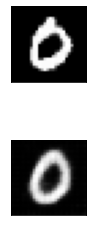

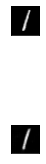

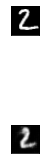

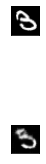

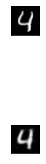

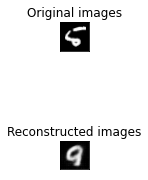

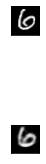

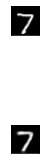

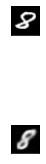

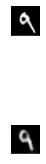

	 partial train loss (single batch): 0.028742
	 partial train loss (single batch): 0.027567
	 partial train loss (single batch): 0.028734
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.029629
	 partial train loss (single batch): 0.028557
	 partial train loss (single batch): 0.027502
	 partial train loss (single batch): 0.028338
	 partial train loss (single batch): 0.028424
	 partial train loss (single batch): 0.029948
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.028562
	 partial train loss (single batch): 0.029939
	 partial train loss (single batch): 0.027237
	 partial train loss (single batch): 0.027401
	 partial train loss (single batch): 0.028361
	 partial train loss (single batch): 0.027468
	 partial train loss (single batch): 0.027804
	 partial train loss (single batch): 0.028221
	 partial train loss (single batch): 0.029841
	 partial train loss (single batch): 0.028214
	 partial train loss (single batch

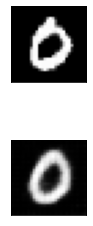

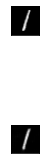

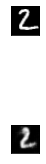

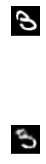

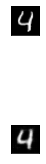

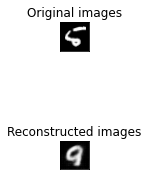

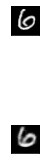

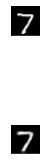

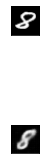

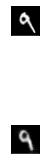

	 partial train loss (single batch): 0.028494
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.028603
	 partial train loss (single batch): 0.027392
	 partial train loss (single batch): 0.029408
	 partial train loss (single batch): 0.028354
	 partial train loss (single batch): 0.027290
	 partial train loss (single batch): 0.028207
	 partial train loss (single batch): 0.028196
	 partial train loss (single batch): 0.029703
	 partial train loss (single batch): 0.028001
	 partial train loss (single batch): 0.028382
	 partial train loss (single batch): 0.029733
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch): 0.028242
	 partial train loss (single batch): 0.027344
	 partial train loss (single batch): 0.027657
	 partial train loss (single batch): 0.028078
	 partial train loss (single batch): 0.029668
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch

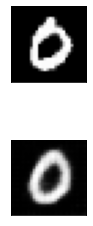

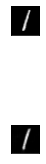

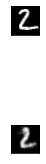

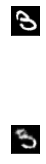

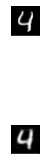

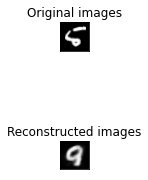

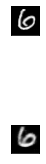

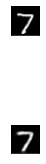

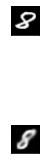

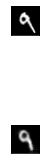

	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.027306
	 partial train loss (single batch): 0.028436
	 partial train loss (single batch): 0.027316
	 partial train loss (single batch): 0.029159
	 partial train loss (single batch): 0.028148
	 partial train loss (single batch): 0.027107
	 partial train loss (single batch): 0.027926
	 partial train loss (single batch): 0.028008
	 partial train loss (single batch): 0.029597
	 partial train loss (single batch): 0.027839
	 partial train loss (single batch): 0.028236
	 partial train loss (single batch): 0.029442
	 partial train loss (single batch): 0.026991
	 partial train loss (single batch): 0.027116
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch): 0.027169
	 partial train loss (single batch): 0.027472
	 partial train loss (single batch): 0.027907
	 partial train loss (single batch): 0.029563
	 partial train loss (single batch): 0.027845
	 partial train loss (single batch

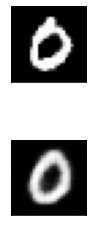

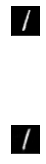

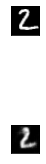

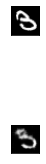

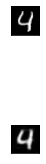

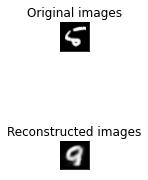

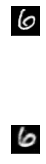

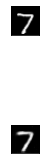

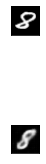

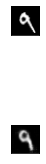

	 partial train loss (single batch): 0.028073
	 partial train loss (single batch): 0.027385
	 partial train loss (single batch): 0.028371
	 partial train loss (single batch): 0.027058
	 partial train loss (single batch): 0.029088
	 partial train loss (single batch): 0.027990
	 partial train loss (single batch): 0.026999
	 partial train loss (single batch): 0.027782
	 partial train loss (single batch): 0.027989
	 partial train loss (single batch): 0.029466
	 partial train loss (single batch): 0.027783
	 partial train loss (single batch): 0.028159
	 partial train loss (single batch): 0.029404
	 partial train loss (single batch): 0.026913
	 partial train loss (single batch): 0.026960
	 partial train loss (single batch): 0.027895
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.029381
	 partial train loss (single batch): 0.027788
	 partial train loss (single batch

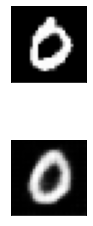

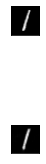

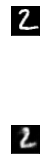

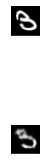

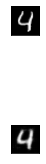

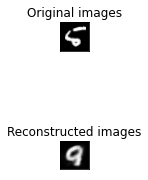

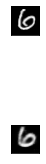

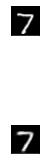

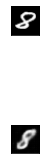

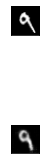

	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.028217
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.028818
	 partial train loss (single batch): 0.027833
	 partial train loss (single batch): 0.026879
	 partial train loss (single batch): 0.027593
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.029377
	 partial train loss (single batch): 0.027650
	 partial train loss (single batch): 0.028100
	 partial train loss (single batch): 0.029259
	 partial train loss (single batch): 0.026755
	 partial train loss (single batch): 0.026834
	 partial train loss (single batch): 0.027808
	 partial train loss (single batch): 0.027008
	 partial train loss (single batch): 0.027256
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.029326
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch

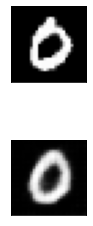

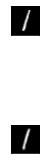

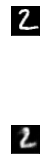

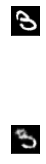

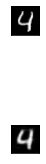

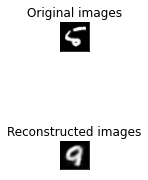

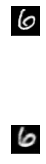

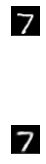

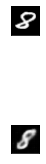

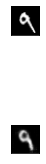

	 partial train loss (single batch): 0.027735
	 partial train loss (single batch): 0.027110
	 partial train loss (single batch): 0.028124
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.028709
	 partial train loss (single batch): 0.027672
	 partial train loss (single batch): 0.026796
	 partial train loss (single batch): 0.027380
	 partial train loss (single batch): 0.027810
	 partial train loss (single batch): 0.029182
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.027959
	 partial train loss (single batch): 0.029066
	 partial train loss (single batch): 0.026649
	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.026946
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch): 0.027511
	 partial train loss (single batch): 0.029247
	 partial train loss (single batch): 0.027518
	 partial train loss (single batch

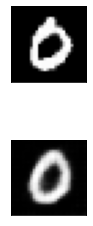

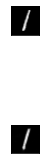

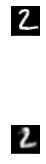

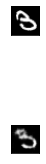

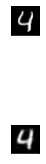

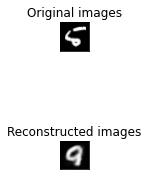

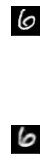

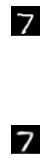

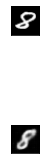

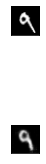

	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.028116
	 partial train loss (single batch): 0.026709
	 partial train loss (single batch): 0.028590
	 partial train loss (single batch): 0.027488
	 partial train loss (single batch): 0.026669
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.029029
	 partial train loss (single batch): 0.027364
	 partial train loss (single batch): 0.027852
	 partial train loss (single batch): 0.028909
	 partial train loss (single batch): 0.026450
	 partial train loss (single batch): 0.026648
	 partial train loss (single batch): 0.027539
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch): 0.027395
	 partial train loss (single batch): 0.029095
	 partial train loss (single batch): 0.027399
	 partial train loss (single batch

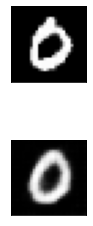

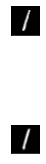

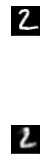

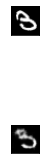

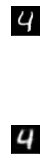

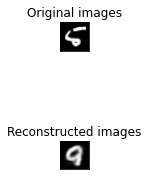

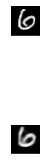

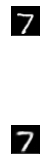

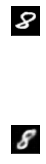

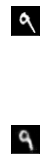

	 partial train loss (single batch): 0.027438
	 partial train loss (single batch): 0.026908
	 partial train loss (single batch): 0.027999
	 partial train loss (single batch): 0.026610
	 partial train loss (single batch): 0.028501
	 partial train loss (single batch): 0.027404
	 partial train loss (single batch): 0.026565
	 partial train loss (single batch): 0.027165
	 partial train loss (single batch): 0.027620
	 partial train loss (single batch): 0.028910
	 partial train loss (single batch): 0.027268
	 partial train loss (single batch): 0.027765
	 partial train loss (single batch): 0.028830
	 partial train loss (single batch): 0.026399
	 partial train loss (single batch): 0.026518
	 partial train loss (single batch): 0.027436
	 partial train loss (single batch): 0.026743
	 partial train loss (single batch): 0.026996
	 partial train loss (single batch): 0.027258
	 partial train loss (single batch): 0.028924
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch

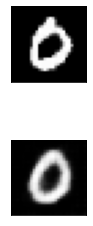

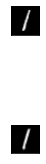

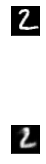

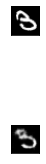

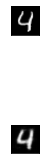

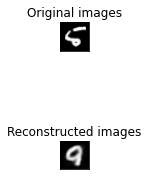

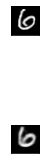

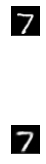

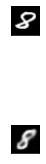

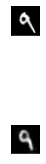

	 partial train loss (single batch): 0.027375
	 partial train loss (single batch): 0.026834
	 partial train loss (single batch): 0.027853
	 partial train loss (single batch): 0.026489
	 partial train loss (single batch): 0.028297
	 partial train loss (single batch): 0.027229
	 partial train loss (single batch): 0.026462
	 partial train loss (single batch): 0.026962
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch): 0.028798
	 partial train loss (single batch): 0.027163
	 partial train loss (single batch): 0.027618
	 partial train loss (single batch): 0.028753
	 partial train loss (single batch): 0.026193
	 partial train loss (single batch): 0.026474
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.026634
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.027147
	 partial train loss (single batch): 0.028820
	 partial train loss (single batch): 0.027203
	 partial train loss (single batch

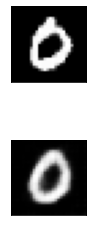

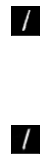

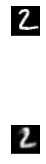

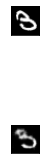

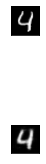

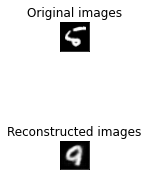

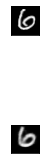

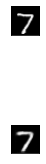

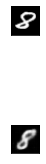

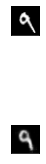

	 partial train loss (single batch): 0.027268
	 partial train loss (single batch): 0.026760
	 partial train loss (single batch): 0.027812
	 partial train loss (single batch): 0.026342
	 partial train loss (single batch): 0.028163
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.026344
	 partial train loss (single batch): 0.026778
	 partial train loss (single batch): 0.027308
	 partial train loss (single batch): 0.028652
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.027521
	 partial train loss (single batch): 0.028721
	 partial train loss (single batch): 0.026114
	 partial train loss (single batch): 0.026415
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.026855
	 partial train loss (single batch): 0.027046
	 partial train loss (single batch): 0.028596
	 partial train loss (single batch): 0.027085
	 partial train loss (single batch

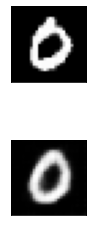

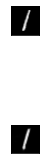

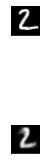

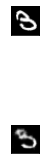

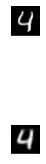

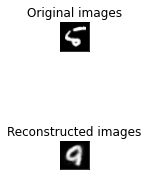

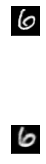

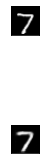

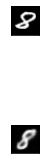

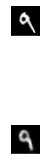

	 partial train loss (single batch): 0.027159
	 partial train loss (single batch): 0.026729
	 partial train loss (single batch): 0.027707
	 partial train loss (single batch): 0.026238
	 partial train loss (single batch): 0.028100
	 partial train loss (single batch): 0.027009
	 partial train loss (single batch): 0.026287
	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.028652
	 partial train loss (single batch): 0.027021
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.028628
	 partial train loss (single batch): 0.026023
	 partial train loss (single batch): 0.026336
	 partial train loss (single batch): 0.027144
	 partial train loss (single batch): 0.026399
	 partial train loss (single batch): 0.026742
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.028459
	 partial train loss (single batch): 0.027028
	 partial train loss (single batch

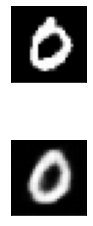

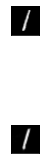

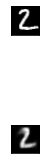

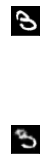

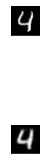

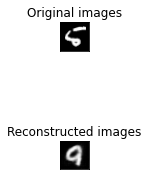

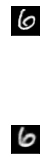

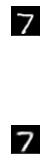

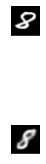

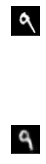

	 partial train loss (single batch): 0.027080
	 partial train loss (single batch): 0.026735
	 partial train loss (single batch): 0.027652
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.027958
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.026280
	 partial train loss (single batch): 0.026583
	 partial train loss (single batch): 0.027062
	 partial train loss (single batch): 0.028416
	 partial train loss (single batch): 0.026979
	 partial train loss (single batch): 0.027259
	 partial train loss (single batch): 0.028521
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.026243
	 partial train loss (single batch): 0.027047
	 partial train loss (single batch): 0.026289
	 partial train loss (single batch): 0.026616
	 partial train loss (single batch): 0.026865
	 partial train loss (single batch): 0.028335
	 partial train loss (single batch): 0.026847
	 partial train loss (single batch

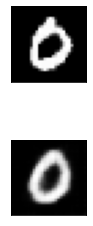

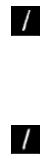

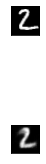

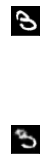

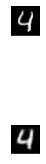

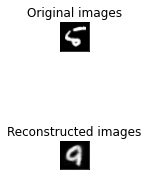

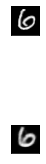

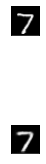

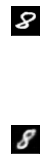

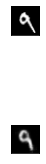

	 partial train loss (single batch): 0.027004
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.027558
	 partial train loss (single batch): 0.026163
	 partial train loss (single batch): 0.027967
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.026176
	 partial train loss (single batch): 0.026521
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.028237
	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.027126
	 partial train loss (single batch): 0.028458
	 partial train loss (single batch): 0.025788
	 partial train loss (single batch): 0.026109
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.026281
	 partial train loss (single batch): 0.026490
	 partial train loss (single batch): 0.026789
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.026737
	 partial train loss (single batch

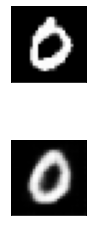

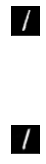

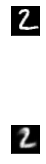

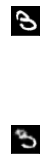

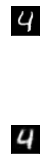

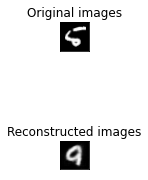

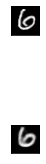

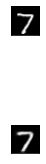

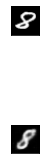

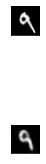

	 partial train loss (single batch): 0.026977
	 partial train loss (single batch): 0.026606
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.026179
	 partial train loss (single batch): 0.027880
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.026374
	 partial train loss (single batch): 0.026900
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.026871
	 partial train loss (single batch): 0.027023
	 partial train loss (single batch): 0.028388
	 partial train loss (single batch): 0.025791
	 partial train loss (single batch): 0.026113
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.026243
	 partial train loss (single batch): 0.026406
	 partial train loss (single batch): 0.026620
	 partial train loss (single batch): 0.028135
	 partial train loss (single batch): 0.026705
	 partial train loss (single batch

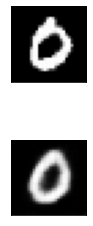

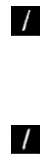

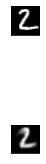

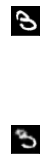

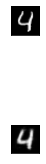

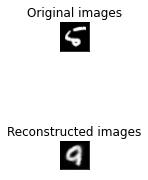

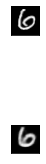

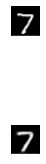

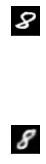

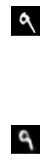

In [18]:
num_epochs = 30
diz_loss = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
  train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)
  val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
  print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  plot_ae_outputs(encoder, decoder, n=10)

# testing model

In [19]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.027004500851035118

# loss graph

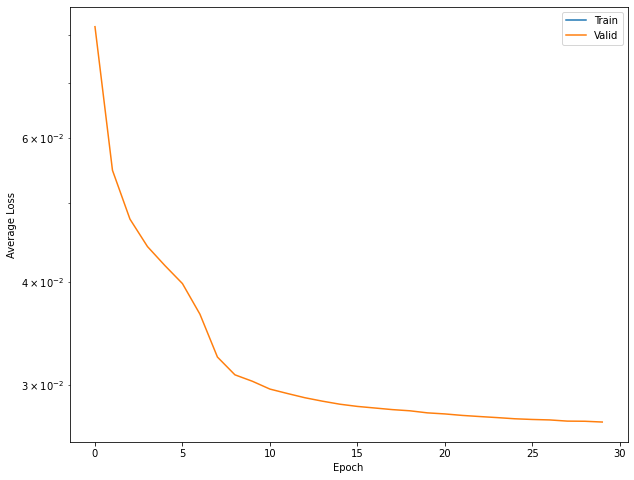

In [20]:
plt.figure(figsize = (10, 8))
plt.semilogy(diz_loss['train_loss'], label = "Train")
plt.semilogy(diz_loss['val_loss'], label = "Valid")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

plt.legend()

plt.show()

tensor([-0.0277, -0.2128, -0.1025,  0.0157])
tensor([0.6914, 0.6902, 0.5873, 0.6291])


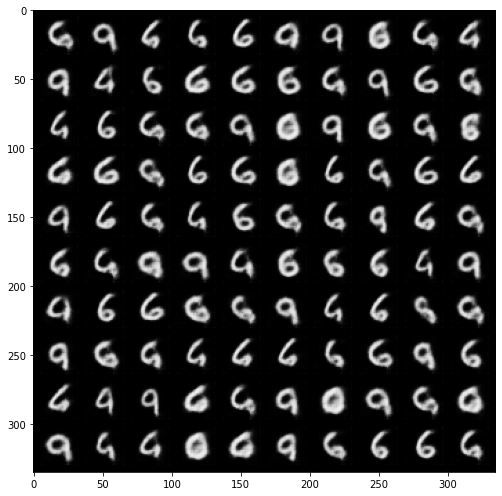

In [21]:
def show_image(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
  images, labels = iter(test_loader).next()
  images = images.to(device)
  latent = encoder(images)
  latent = latent.cpu()

  mean = latent.mean(dim = 0)
  print(mean)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()
  print(std)

  #sample latent vectors from the normal dist
  latent = torch.rand(128, d)*std + mean

  #reconstruct images from the random latent vectors
  latent = latent.to(device)
  img_recon = decoder(latent)
  img_recon = img_recon.cpu()

  fig, ax = plt.subplots(figsize = (20, 8.5))
  show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))
  plt.show()

In [24]:
from tqdm import tqdm_notebook as tqdm

encoded_samples = []

for sample in tqdm(test_dataset):
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]

  #encode image yay
  encoder.eval()
  with torch.no_grad():
    encoded_img = encoder(img)
  
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  encoded_sample['label'] = label
  encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

/tmp/ipykernel_985/1128042213.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test_dataset):


  0%|          | 0/10000 [00:00<?, ?it/s]

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            1.203291        -1.723759        -0.910214        -1.426003   
1           -0.791480         0.085541        -0.661644         0.635387   
2           -0.111525         0.162999        -1.405885        -0.263130   
3           -0.372634        -0.049933         0.577787         0.316547   
4            0.717646         0.626987         0.167601        -0.326227   
...               ...              ...              ...              ...   
9995        -1.603366        -0.558570        -0.599383         0.832878   
9996        -0.696514        -1.345890        -0.133448         1.038259   
9997         0.406223         0.377716        -0.339143        -1.037187   
9998        -0.655073        -0.234791         0.765060        -1.215926   
9999        -0.120649         0.303662         0.391375         0.316403   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [23]:
!pip install plotly

In [22]:
!jupyter labextension install jupyterlab-plotly

Building jupyterlab assets (production, minimized)


# latent space visualization

In [25]:
import plotly.express as px

px.scatter(encoded_samples, x = 'Enc. Variable 0', y = 'Enc. Variable 1', color = encoded_samples.label.astype(str), opacity = 0.7)

# t-sne that latent space

In [26]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components = 2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis = 1))
fig = px.scatter(tsne_results, x=0, y=1, color = encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

fig.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

